![](https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png)

# Model-Data Confrontation in the Spectral Domain
In this notebook, we demonstrate the use of the spectral analysis features of [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/master/index.html) and reproduce the results of [Zhu et al. (2019)](https://www.pnas.org/content/early/2019/04/09/1809959116).
The goal is to perform comparison of the climate variability across scales simulated by climate models and observed in proxy records.

## Table of Contents
* [Data](#data)
    * [PIMP3 last millennium simulations](#pmip3)
    * [Proxies, LMR, and deglacal simulations](#proxy)
* [Spectral analysis](#spec)
    * [A WWZ perspective](#wwz)
    * [Visualization of the PSDs](#viz)
    * [Estimation of the scaling exponents](#slope)
* [References](#ref)

## <a name='data'>Data Exploration</a>

### <a name='pmip3'>PMIP3 last millennium simulations</a>

The PMIP3 (Braconnot et al. 2012) simulations  of the past millennium ([past1000](https://wiki.lsce.ipsl.fr/pmip3/doku.php/pmip3:design:lm:final)) of global mean surface temperature (GMST) are stored in a text file and can be imported with `Pandas` conveniently.

In [20]:
import pandas as pd
import numpy as np

# load the raw data
df = pd.read_table('./data/PMIP3_GMST.txt')

# display the raw data
df

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,GISS-E2-R_r1i1p121,GISS-E2-R_r1i1p127,...,CESM_member_1,CESM_member_2,CESM_member_3,CESM_member_4,CESM_member_5,CESM_member_6,CESM_member_7,CESM_member_8,CESM_member_9,CESM_member_10
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,0.116333,0.155407,...,0.036672,0.067692,0.085340,-0.000616,0.157021,0.048458,0.038173,-0.027151,0.143404,-0.053464
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,0.068174,0.210337,...,0.246816,0.181400,0.251417,0.170710,0.165139,0.324856,0.191677,0.120951,0.216921,0.068698
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,0.060088,0.240585,...,0.187429,0.065922,0.190229,0.264551,0.092629,0.386593,0.068904,0.292246,0.101564,0.200259
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.074396,0.030596,...,0.202443,0.089054,-0.031298,0.205805,0.049447,0.023312,-0.041356,0.206064,0.212954,0.288272
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.402800,-0.330589,...,0.062795,0.137882,-0.233049,-0.227240,-0.156577,-0.339176,-0.103825,0.058420,-0.006102,-0.006619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The file includes several ensemble members for CESM and GISS simulations, for which we substitue their ensemble mean series.

In [4]:
# create a new pandas.DataFrame to store the processed data
df_new = df.copy()

# remove the data columns for CESM and GISS ensemble members
for i in range(10):
    df_new = df_new.drop([f'CESM_member_{i+1}'], axis=1)
    
df_new = df_new.drop(['GISS-E2-R_r1i1p127.1'], axis=1)
df_new = df_new.drop(['GISS-E2-R_r1i1p127'], axis=1)
df_new = df_new.drop(['GISS-E2-R_r1i1p121'], axis=1)

# calculate the ensemble mean for CESM and GISS, and add the results into the table
df_new['CESM'] = df[[f'CESM_member_{i+1}' for i in range(10)]].mean(axis=1)

df_new['GISS'] = df[[
    'GISS-E2-R_r1i1p127.1',   
    'GISS-E2-R_r1i1p127',
    'GISS-E2-R_r1i1p121',
]].mean(axis=1)

# display the processed data
df_new

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,HadCM3,CESM,GISS
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,-0.620517,0.049553,0.127429
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,-0.553043,0.193858,0.138796
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,-0.560791,0.185033,0.098170
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.438949,0.120470,-0.054552
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.812194,-0.081349,-0.407169
...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`pyleoclim` capabilities can now be leveraged.
We now define a `pyleoclim.Series` object for each simulated GMST time series.
A `pyleoclim.Series` represents a time series object that comes with a collection of methods, such as performing spectral analysis, wavelet analysis, interpolation, plotting, and so on.
For details, see [the documentation](https://pyleoclim-util.readthedocs.io/en/stable/core/ui.html#series-pyleoclim-series).

In [5]:
import pyleoclim as pyleo

# store each pyleoclim.Series() object into a dictionary
ts_dict = {}
for name in df_new.columns[1:]:
    ts_dict[name] = pyleo.Series(
        time=df_new['Year'].values,  # the time axis
        value=df_new[name].values,   # the value axis
        label=name,                  # optional metadata: the nickname of the series
        time_name='Time',            # optional metadata: the name of the time axis
        time_unit='yrs',             # optional metadata: the unit of the time axis
        value_name='GMST anom.',     # optional metadata: the name of the value axis
        value_unit='K',              # optional metadata: the unit of the value axis
    )

Once a `pyleoclim.Series` is defined, we can easily visualize it by calling the `pyleoclim.Series.plot()` method.
For instance, we plot the CCSM4 GMST below:

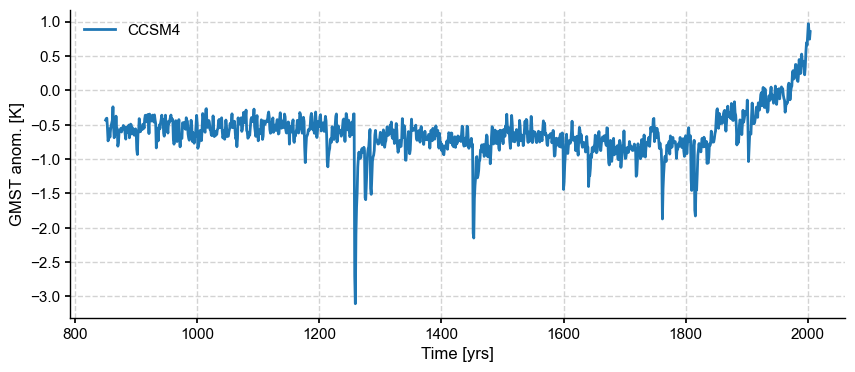

In [6]:
fig, ax = ts_dict['CCSM4'].plot()

Note that the return of the `plot()` method is a list of a `matplotlib.pyplot.figure` and a `matplotlib.pyplot.axis`.
That means all possible `matplotlib` manipulations can follow.
For instance, let's change the limit of the y-axis and the label below.

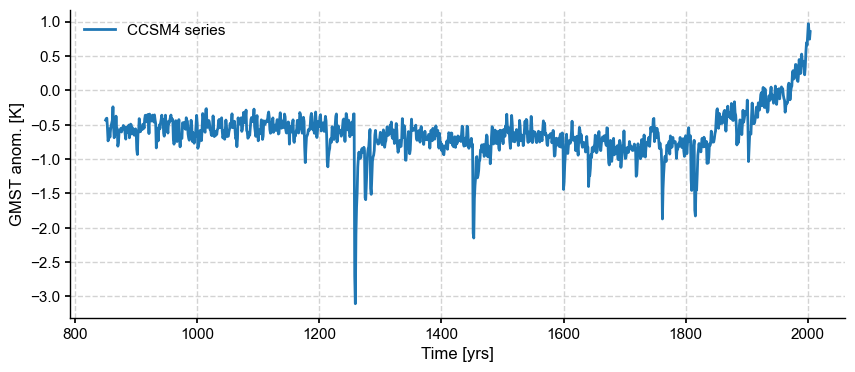

(-4.0, 2.0)

In [7]:
fig, ax = ts_dict['CCSM4'].plot(label='CCSM4 series')
ax.set_ylim([-4, 2])

With the same mechanism, we may plot two time series in the same figure as following, in which we use the argument `ax=ax` to specify that the we'd like to plot the series of GISS into the same `matplotlib.pyplot.axis`.

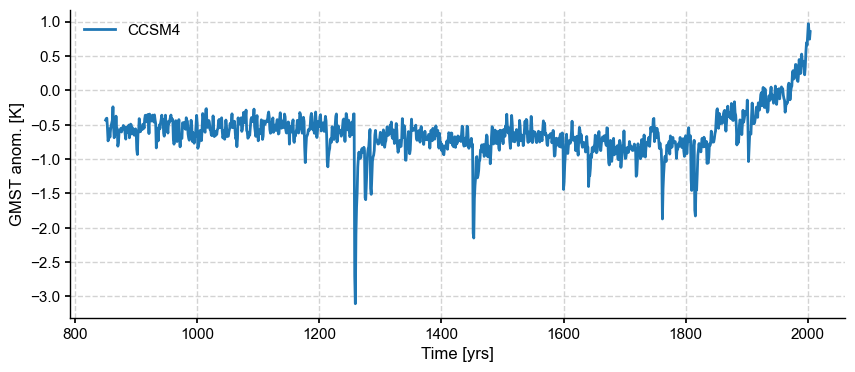

(-4.0, 2.0)

In [8]:
fig, ax = ts_dict['CCSM4'].plot()
ts_dict['GISS'].plot(ax=ax)  # the argument "ax=ax" indicates we'd like to plot into the "ax" we got from the previous line of code 
ax.set_ylim([-4, 2])

To plot a collection of time series at once, we define a `pyleoclim.MultipleSeries` object, which takes a list of `pyleoclim.Series` objects as input.

Since we have defined a dictionary of a collection of `pyleoclim.Series` objects, we may first convert this dictionary into a list, and then use that list to define a `pyleoclim.MultipleSeries` object.

In [9]:
ts_list = [v for k, v in ts_dict.items()]  # a pythonic way to convert the pyleo.Series items in the dictionary to a list
ms_pmip = pyleo.MultipleSeries(ts_list)

Now that the `pyleoclim.MultipleSeries` called "ms_pmip" is defined, we can visualize all the time series at once by calling the `pyleoclim.MultipleSeries.plot()` method.

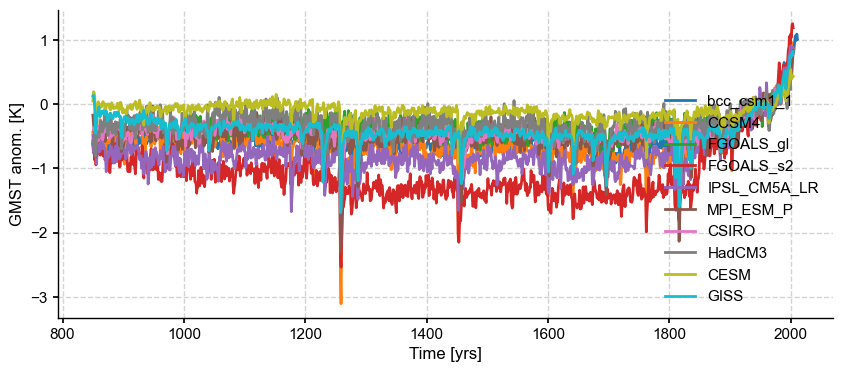

In [10]:
fig, ax = ms_pmip.plot()

You may notice that the legend is not in its best place, and we may want to move it to the right side.
We can achieve that by passing a dictionary of arguments for `matplotlib.pyplot.axis.legend()` (see the [matplotlib documentation](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.legend.html) for details) as below:

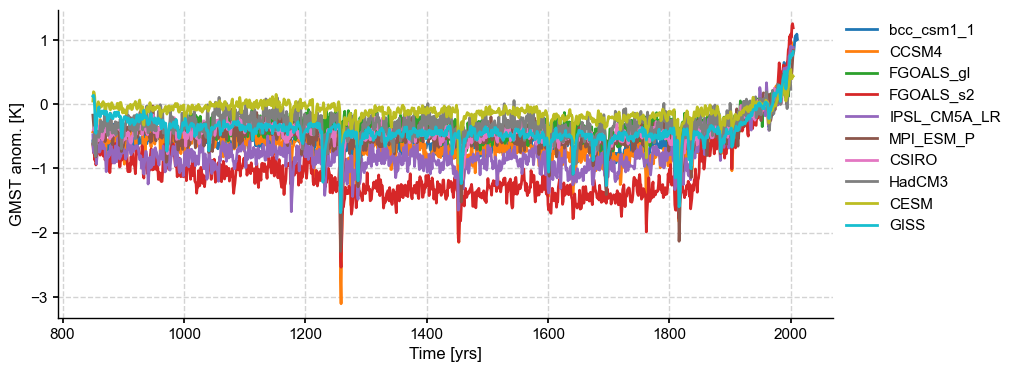

In [11]:
fig, ax = ms_pmip.plot(lgd_kwargs={'bbox_to_anchor': (1, 1)})  # move the legend to the right side

Now that the loading of PMIP3 simulations is complete, let's move on to proxies, the [last millennium reanalysis](https://cpo.noaa.gov/News/News-Article/ArtMID/6226/ArticleID/1807/Last-Millennium-Reanalysis-now-at-NOAAs-National-Centers-for-Environmental-Information-marking-major-milestone) (LMR, Hakim et al. 2016; Tardif et al. 2019), and deglacial simulations.

## <a name='proxy'>Proxies, LMR, and deglacial simulations</a>

We've preprocessed the data for proxies, LMR (Hakim et al., 2016; Tardif et al., 2019), and deglacial simulations, and stored them in a [Python pickle](https://docs.python.org/3/library/pickle.html) file, which includes two dictionaries called `ts` and `vs`.
`ts` includes the time axis for each dataset,
and `vs` includes the GMST for each dataset.

We load the pickle file below and print out the dictionary keys to see how many datasets we have.

In [12]:
ts, vs = pd.read_pickle('./data/PNAS19_data.pkl')
print(vs.keys())

dict_keys(['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR', 'trace21ka_full', 'trace21ka_mwf', 'trace21ka_orb', 'trace21ka_ghg', 'trace21ka_ice', 'DGns', 'SIM2bl'])


As before, we extract the data and organize them in `Series` objects:

In [13]:
for name in vs.keys():
    # we may specify specific metadata for each dataset with the if-clauses
    if name == 'LMR':
        value_name = 'GSMT anom.'
        value_unit = 'K'
    elif name in ['trace21ka_full', 'DGns', 'SIM2bl']:
        value_name = 'GSMT'
        value_unit = 'K'
    else:
        value_name = 'Proxy Value'
        value_unit = None
        
    if name == 'trace21ka_full':
        label = 'TraCE-21ka'
    elif name in ['trace21ka_mwf', 'trace21ka_orb', 'trace21ka_ghg', 'trace21ka_ice']:
        continue
    else:
        label = name
        
    ts_dict[name] = pyleo.Series(
        time=ts[name],
        value=vs[name],
        label=label,
        time_name='Time',
        time_unit='yrs',
        value_name=value_name,
        value_unit=value_unit,
    )

Now we define a `MultipleSeries` object for each group of datasets:

In [14]:
ms_obs = pyleo.MultipleSeries(
    [ts_dict[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack']]
)
ms_deglacial = pyleo.MultipleSeries(
    [ts_dict[name] for name in ['trace21ka_full', 'DGns', 'SIM2bl']]
)

Now we visualize what we have.
LMR first.

Note that here we use the median of the LMR ensembles for our analysis for simplicity and calculation speed, while all the ensemble members are being analyzed in the original paper, so the estimated scaling slope value that we show later would be a bit different from that in the original paper. 

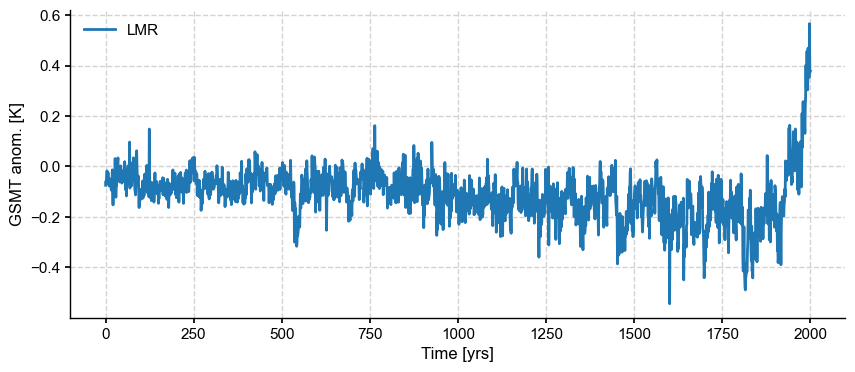

In [15]:
fig, ax = ts_dict['LMR'].plot()

Then the proxies.

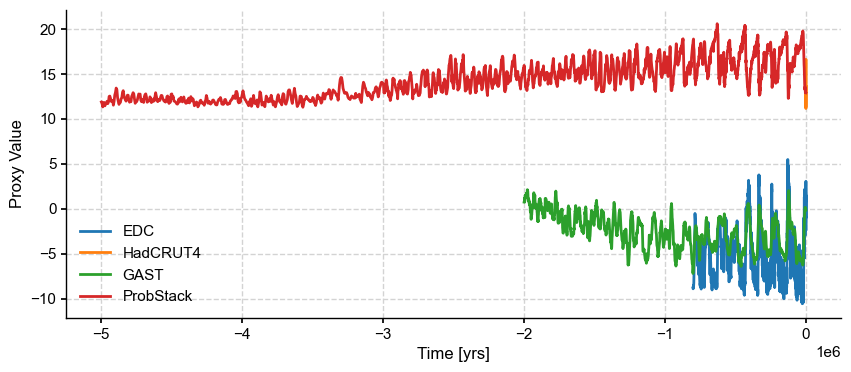

In [16]:
fig, ax = ms_obs.plot()

We notice that the time axis is in unit of years by default, which is odd for paleo-records prior to CE.
We can easily convert the time unit to "kyrs BP" by calling the `pyleoclim.MultipleSeries.convert_time_unit` method as below:

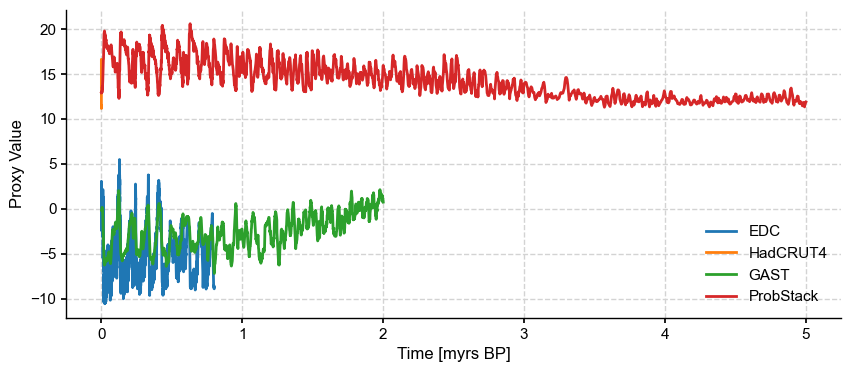

In [17]:
ms_obs = ms_obs.convert_time_unit('myrs BP')
fig, ax = ms_obs.plot()

Now the time unit is "myrs BP", and the numerical time values are ascending.
What if we wanted to present the data in a way that the right hand side represents more recent time? We can manipulate the returned `matplotlib.pyplot.axis` object as mentioned earlier, or just use the `invert_xais=True` argument of the `pyleoclim.MultipleSeries.plot()` method as below:

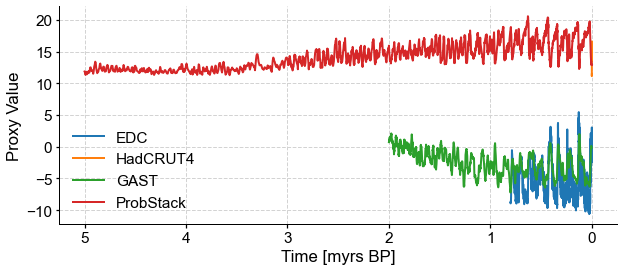

In [23]:
fig, ax = ms_obs.plot(invert_xaxis=True)

Similarly, we convert the time unit of deglacial simulations to "kyrs BP" and then visualize them with the x-axis inverted and the lelgend location moved to the right side.

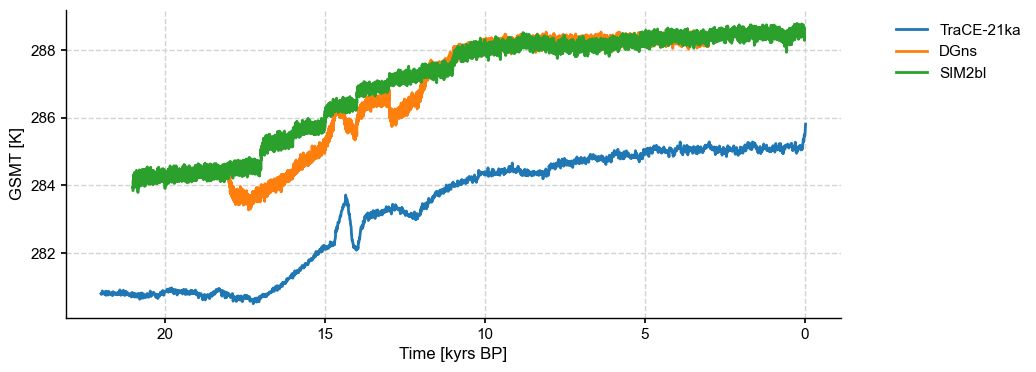

In [18]:
ms_deglacial = ms_deglacial.convert_time_unit('kyrs BP')
fig, ax = ms_deglacial.plot(
    lgd_kwargs={
        'loc': 'upper right',         # put the legend anchor to the upper right corner
        'bbox_to_anchor': (1.25, 1),  # move the legend to the right side
    },
    invert_xaxis=True,
)

Now that all data needed has been loaded, let's perform spectral analysis using the Weighted Wavelet Z-transform method (WWZ, Foster 1996; Kirchner & Neal 2013), which can handle unevenly-spaced data without interpolation.

## <a name='spec'>Spectral analysis</a>

### <a name='wwz'>A WWZ perspective</a>

We may perform spectral analysis on time series by calling the `pyleoclim.Series.spectral()` method.
It has the argument `method` to specify which method to use. It is set to `wwz` by default to use the WWZ method. 
It also has an argument `freq_method` to specify the approach to generate the frequency vector for the analysis.
It is set to `log` by default to use generate the frequency vector in a log space.
Here, we set to `nfft` so that we can reproduce the result in the original paper [Zhu et al. (2019)](https://www.pnas.org/content/early/2019/04/09/1809959116).
Other arguments specific to each spectral analysis method can be passed in through the argument `settings`.
Since WWZ is originally a wavelet analysis method, we may specify `tau` to specify the evenly-spaced time points (the temporal resolution) for wavelet analysis.
However, since our purpose here is spectral analysis, the temporal resolution is not required to be high, and we may use small values to accelerate the calculation.
Please see the documentation on [pyleoclim.Series.spectral](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.series.Series.spectral) and the [wwz_psd](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.spectral.wwz_psd) function that `pyeloclim.Series.spectral` called for details.

The method will return a [pyleoclim.PSD](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#psd-pyleoclim-psd) object, which includes the estimated power spectral density (PSD) along with the information of the frequency axis, and the object iteself is intended for lalter operations such as visualization, scaling slope estimation, and significance test.

Note that to reproduce exactly the result in the paper, we need to use settings in the cell below (that's commented out), which could be slow (> 5 mins).
For the sake of time, we may load a file with pre-calculated results.

In [21]:
%%time

# we will store the result in a dictionary with the dataset names as keys
psd_wwz = {}
for name, ts in ts_dict.items():
    print(f'Processing {name} ...')
    print(f'Data length: {np.size(ts.time)}')
    if name in ['DGns', 'SIM2bl']:
        ntau = 51  # to accelerate the calculation; the smaller, the faster
    else:
        ntau = 501
    tau = np.linspace(np.min(ts.time), np.max(ts.time), ntau)
    psd_wwz[name] = ts.spectral(method='wwz', freq_method='nfft', settings={'tau': tau})

pd.to_pickle(psd_wwz, './data/PNAS19_psd.pkl')

Processing bcc_csm1_1 ...
Data length: 1162
Processing CCSM4 ...
Data length: 1155
Processing FGOALS_gl ...
Data length: 999
Processing FGOALS_s2 ...
Data length: 1155
Processing IPSL_CM5A_LR ...
Data length: 1155
Processing MPI_ESM_P ...
Data length: 1155
Processing CSIRO ...
Data length: 1150
Processing HadCM3 ...
Data length: 1151
Processing CESM ...
Data length: 1155
Processing GISS ...
Data length: 1155
Processing EDC ...
Data length: 5785
Processing HadCRUT4 ...
Data length: 2015
Processing GAST ...
Data length: 2000
Processing ProbStack ...
Data length: 2051
Processing LMR ...
Data length: 2001
Processing trace21ka_full ...
Data length: 2204
Processing DGns ...
Data length: 15000
Processing SIM2bl ...
Data length: 21000
CPU times: user 1h 10min 37s, sys: 16.6 s, total: 1h 10min 53s
Wall time: 5min 57s


In [23]:
# quick loading of the pyleoclim.PSD objects
psd_wwz = pd.read_pickle('./data/PNAS19_psd.pkl')

We may, however, perform the WWZ method with the default settings that makes the calculation faster, and compare with the pre-calculated results.

In [24]:
%%time
psd_wwz_new = {}
for name, ts in ts_dict.items():
    print(f'Processing {name} ...')
    print(f'Data length: {np.size(ts.time)}')
    psd_wwz_new[name] = ts.spectral(method='wwz')

Processing bcc_csm1_1 ...
Data length: 1162
Processing CCSM4 ...
Data length: 1155
Processing FGOALS_gl ...
Data length: 999
Processing FGOALS_s2 ...
Data length: 1155
Processing IPSL_CM5A_LR ...
Data length: 1155
Processing MPI_ESM_P ...
Data length: 1155
Processing CSIRO ...
Data length: 1150
Processing HadCM3 ...
Data length: 1151
Processing CESM ...
Data length: 1155
Processing GISS ...
Data length: 1155
Processing EDC ...
Data length: 5785
Processing HadCRUT4 ...
Data length: 2015
Processing GAST ...
Data length: 2000
Processing ProbStack ...
Data length: 2051
Processing LMR ...
Data length: 2001
Processing trace21ka_full ...
Data length: 2204
Processing DGns ...
Data length: 15000
Processing SIM2bl ...
Data length: 21000
CPU times: user 9min 7s, sys: 8.47 s, total: 9min 16s
Wall time: 1min 52s


Now we compare the results.

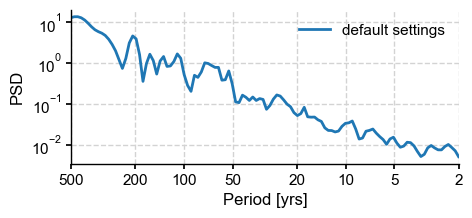

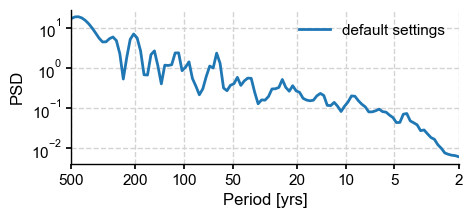

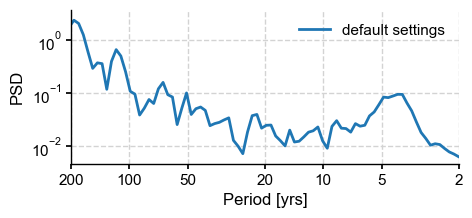

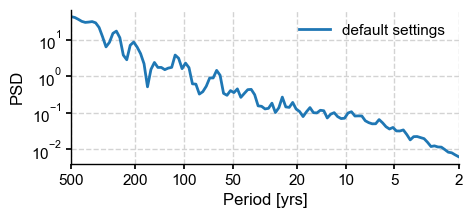

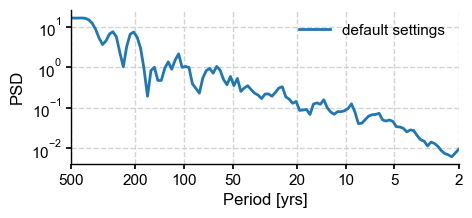

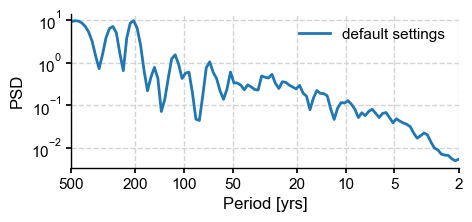

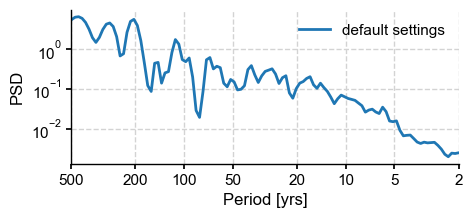

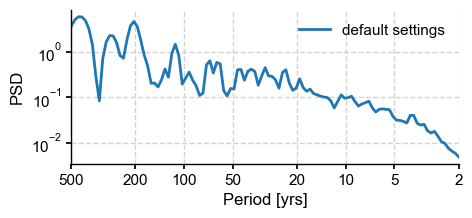

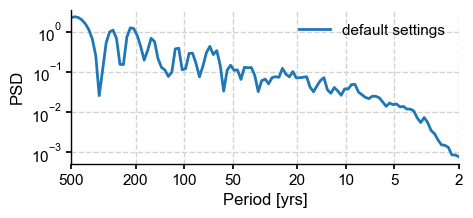

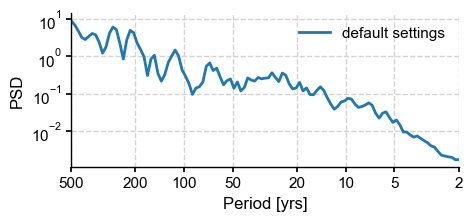

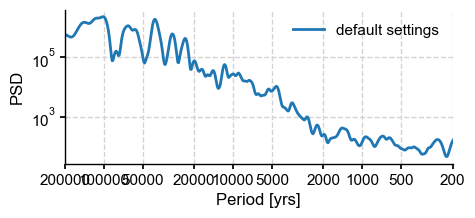

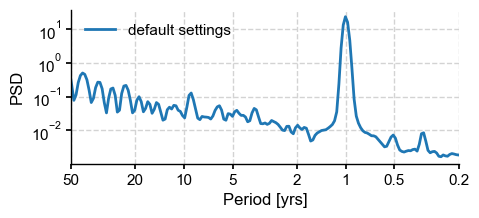

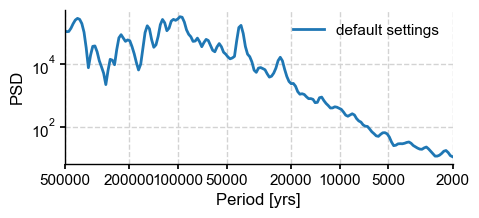

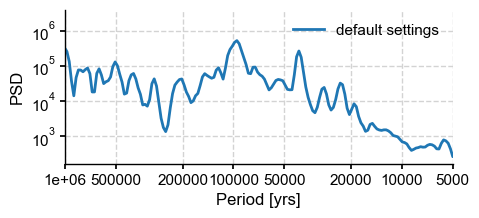

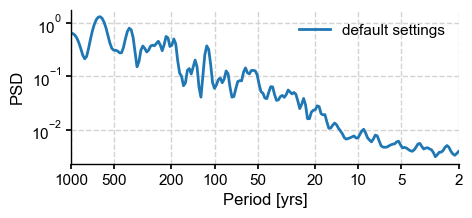

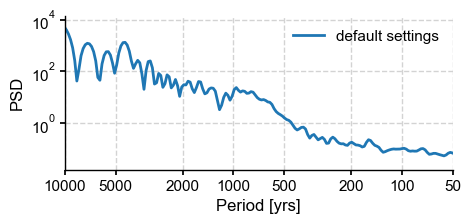

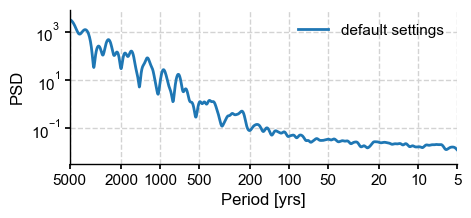

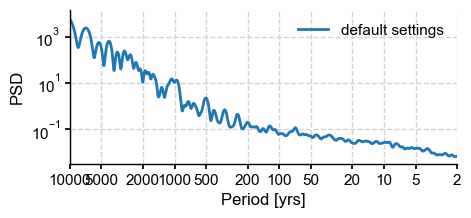

In [30]:
import matplotlib.pyplot as plt
for k in psd_wwz_new.keys():
    fig, ax = psd_wwz_new[k].plot(figsize=[5, 2], label='default settings')
    psd_wwz[k].plot(ax=ax, label='Zhu et al. [2019]', color='red', alpha=1)
    ax.set_title(k)

We see that the difference is overall rather small.
Indeed, the difference is mainly caused by the frequency vector: the results of the paper used a linear spaced frequency vector while the current default settings used a log space vector.
For the following presentation, we will stick with the pre-calculated results of the paper.

### <a name='viz'>Visualization of the PSDs</a>

Now let's visualize the results.
In below cells, we first define a colormap, then specify the colors for each `pyleoclim.PSD` object.
Similar to `pyleoclim.MultipleSeries`, we may also define a `pyleoclim.MultiplePSD` object for a collection of the `pyleoclim.PSD` objects for operations at once.

In [31]:
# define the tableau20 colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

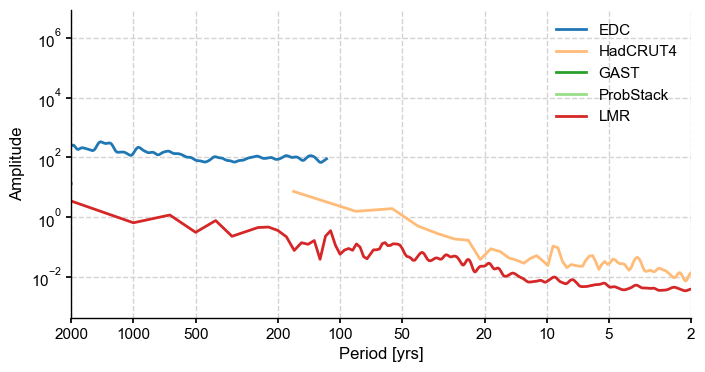

Text(25.078125000000007, 0.5, 'Spectral Density')

In [34]:
# define a dictionary for the colors
clr_dict = {
    'EDC': tableau20[0],
    'HadCRUT4': tableau20[3],
    'GAST': tableau20[4],
    'ProbStack': tableau20[5],
    'LMR': tableau20[6],
}

# specify color for each pyleoclim.PSD objects
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}
    
# for the period axis customization later
period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5, 1e6]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']

# define the pyleoclim.MultiplePSD object and visualize the several pyleoclim.PSD objects at once
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])
fig, ax = mpsd_obs.plot(figsize=[8, 4])
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')

We have reproduced Fig. 1 of the original paper above.

To reproduce the upper panel of Fig. 2, we reset the colors for observations to be grey, and set the opacity via `alpha`, as well as the line width via `linewidth` below.
Note that the colors for the PMIP3 simulations will follow a default list of Python.

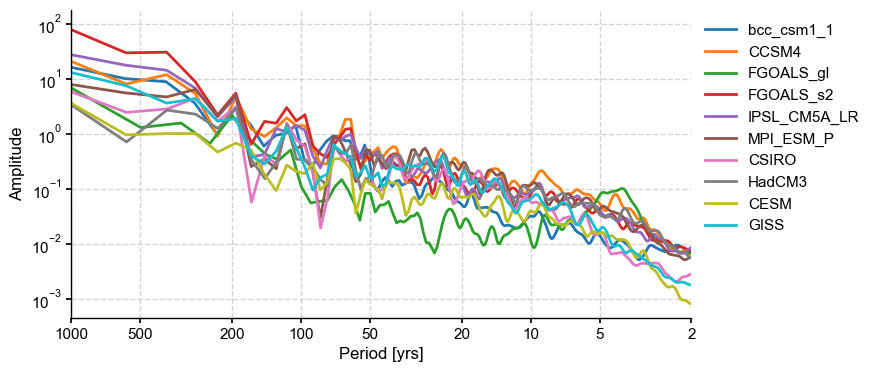

Text(25.078125000000007, 0.5, 'Spectral Density')

In [35]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.3, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])

period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1000, 10000, 100000]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

pmip_names = ['bcc_csm1_1', 'CCSM4', 'FGOALS_gl', 'FGOALS_s2', 'IPSL_CM5A_LR', 'MPI_ESM_P', 'CSIRO', 'HadCM3', 'CESM', 'GISS']
mpsd_pmip = pyleo.MultiplePSD([psd_wwz[name] for name in pmip_names])
fig, ax = mpsd_pmip.plot(figsize=[8, 4], cmap='tab10', lgd_kwargs={'bbox_to_anchor': (1, 1)})
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')

Similarly, we reproduce the lower panel of Fig. 2 of the original paper as below:

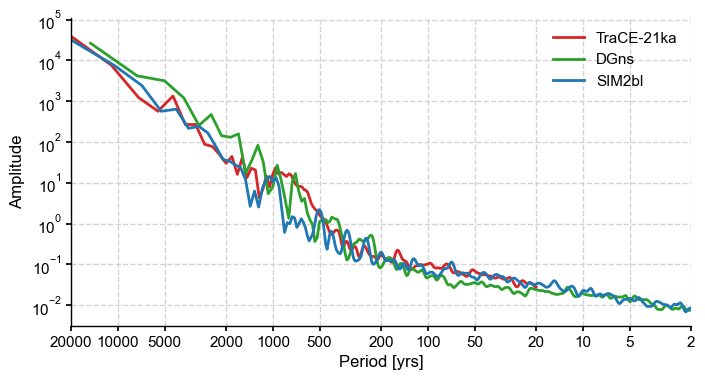

Text(25.078125000000007, 0.5, 'Spectral Density')

In [36]:
clr_deglacial_dict = {
    'trace21ka_full': tableau20[6],
    'DGns': tableau20[4],
    'SIM2bl': tableau20[0],
}
for k, v in clr_deglacial_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}


period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1000, 10000, 100000]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

mpsd_deglacial = pyleo.MultiplePSD([psd_wwz[name] for name in ['trace21ka_full', 'DGns', 'SIM2bl']])
fig, ax = mpsd_deglacial.plot(figsize=[8, 4])
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')

### <a name='slope'>Estimation of the scaling exponents</a>

You may notice that something is missing comparing our reproduced figures to the figures in the original paper -- the scaling exponents.

Below, we use the `pyleoclim.PSD.beta_est()` method to estimate the scaling exponents for each dataset.
To do that, we need to specify the frequency range over which we estimate.
The estimation is achieved utilizing linear regression in the log-log space.
Since the frequency vector we used is `nfft`, which is defined in a linear space, so the frequency points will be denses over the high frequency band and coarser over the low frequency band, and binning is needed prior to the linear regression, so there's an argument called `logf_binning_step` that we need to set.
While the default is `max`, which means to use the largest spacing for binning, here we use the first spacing of the frequency vector, as per the original paper.

Note that we estimate exponents over two scaling regimes with a break at 400 yrs for the deglacial simualtions.

In [27]:
# define frequency range for the exponent estimation
franges = {
    'EDC': [1/50000, 1/1500],
    'HadCRUT4': [1/50, 6],
    'GAST': [1/100000, 1/2000],
    'ProbStack': [1/100000, 1/10000],
    'LMR': [1/1000, 1/2],
}

# for PMIP simulations, we estimation the scaling slope over 2-500 yrs
for name in pmip_names:
    franges[name] = [1/500, 1/2]

psd_wwz_beta = {}
for name, frange in franges.items():
    psd_wwz_beta[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')
    
# for deglacial model simulations, we have two scaling regimes, one over 20-400 yrs, and another over 400-2000 yrs
s_break = 400
franges_s = {
    'trace21ka_full': [1/s_break, 1/21],  # note that for TraCE-21ka, the slope is estimated over 21-400 yrs due to its temporal resolution 
    'DGns': [1/s_break, 1/20],
    'SIM2bl': [1/s_break, 1/20],
}
franges_l = {
    'trace21ka_full': [1/2000, 1/s_break],
    'DGns': [1/2000, 1/s_break],
    'SIM2bl': [1/2000, 1/s_break],
}

psd_wwz_beta_s = {}
for name, frange in franges_s.items():
    psd_wwz_beta_s[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')
    
psd_wwz_beta_l = {}
for name, frange in franges_l.items():
    psd_wwz_beta_l[name] = psd_wwz[name].beta_est(fmin=frange[0], fmax=frange[-1], logf_binning_step='first')

Now we re-plot the figures with the estimated scaling exponents displayed in the legend and visualized via straight lines in the figure.
Below is for Fig. 1.

Text(0, 0.5, 'Spectral Density')

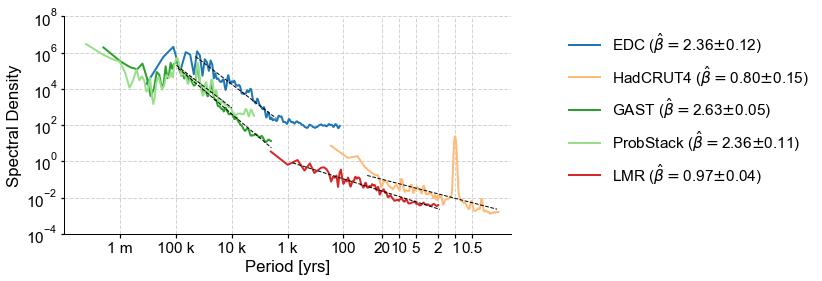

In [28]:
clr_dict = {
    'EDC': tableau20[0],
    'HadCRUT4': tableau20[3],
    'GAST': tableau20[4],
    'ProbStack': tableau20[5],
    'LMR': tableau20[6],
}

for k, v in clr_dict.items():
    psd_wwz_beta[k].plot_kwargs = {'color': v}
    
period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5, 1e6]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k', '1 m']

mpsd_obs = pyleo.MultiplePSD([psd_wwz_beta[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])
fig, ax = mpsd_obs.plot(figsize=[8, 4])
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_xlim([1e7, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')

Then the upper panel of Fig. 2.

Text(0, 0.5, 'Spectral Density')

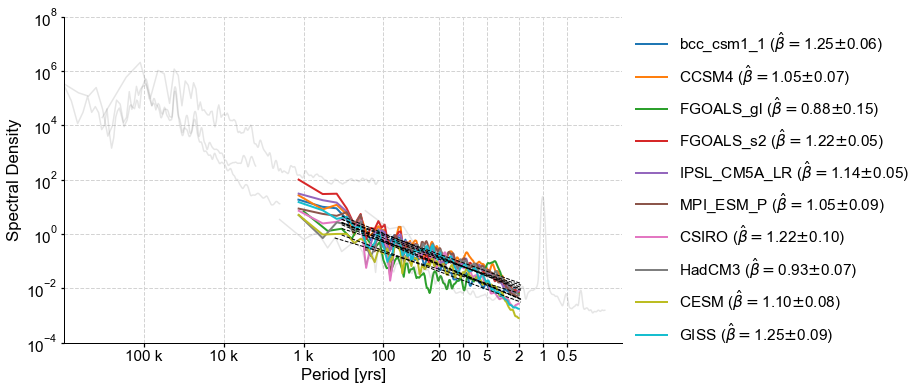

In [29]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.2, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])


mpsd_pmip = pyleo.MultiplePSD([psd_wwz_beta[name] for name in pmip_names])
fig, ax = mpsd_pmip.plot(figsize=[10, 6], cmap='tab10')
ax.legend(bbox_to_anchor=(1, 1))
mpsd_obs.plot(ax=ax, legend=False)

ax.set_xlim([1e6, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)
ax.set_ylabel('Spectral Density')

... and the lower panel of Fig. 2. Note that here we will visualize two scaling regimes, we have to do it manualy with the `PSD.beta_est_res` attribute.

Text(0, 0.5, 'Spectral Density')

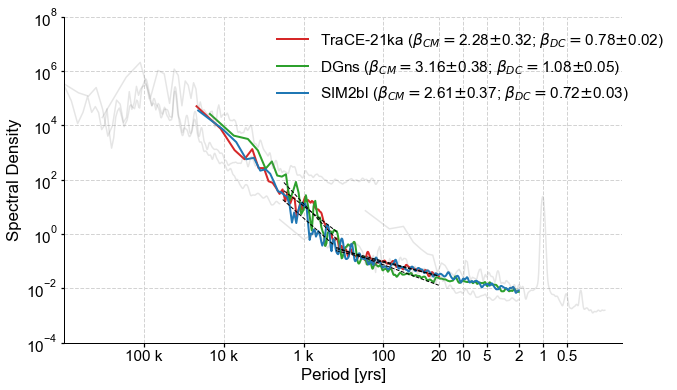

In [30]:
clr_dict = {
    'EDC': 'grey',
    'HadCRUT4': 'grey',
    'GAST': 'grey',
    'ProbStack': 'grey',
    'LMR': 'grey'
}
for k, v in clr_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v, 'alpha': 0.2, 'linewidth': 1.5}
    
mpsd_obs = pyleo.MultiplePSD([psd_wwz[name] for name in ['EDC', 'HadCRUT4', 'GAST', 'ProbStack', 'LMR']])

clr_deglacial_dict = {
    'trace21ka_full': tableau20[6],
    'DGns': tableau20[4],
    'SIM2bl': tableau20[0],
}
for k, v in clr_deglacial_dict.items():
    psd_wwz[k].plot_kwargs = {'color': v}

period_ticks = [0.5, 1, 2, 5, 10, 20, 100, 1e3, 1e4, 1e5]
period_ticklabels = ['0.5', '1', '2', '5', '10', '20', '100', '1 k', '10 k', '100 k']

fig, ax = mpsd_deglacial.plot(figsize=[10, 6])
mpsd_obs.plot(ax=ax, legend=False)
ax.set_xlim([1e6, 0.1])
ax.set_ylim([1e-4, 1e8])
ax.set_xticks(period_ticks)
ax.set_xticklabels(period_ticklabels)

labels = ax.get_legend_handles_labels()[-1]
new_labels = []
i = 0
for name in ['trace21ka_full', 'DGns', 'SIM2bl']:
    res_s = psd_wwz_beta_s[name].beta_est_res
    res_l = psd_wwz_beta_l[name].beta_est_res
    ax.plot(1/res_s['f_binned'], res_s['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    ax.plot(1/res_l['f_binned'], res_l['Y_reg'], linestyle='--', color='k', linewidth=1, zorder=99)
    beta_s_str = r'$\beta_{DC}$'
    beta_s = res_s['beta']
    err_s = res_s['std_err']
    beta_l_str = r'$\beta_{CM}$'
    beta_l = res_l['beta']
    err_l = res_l['std_err']
    new_labels.append(fr'{labels[i]} ({beta_l_str}$=${beta_l:.2f}$\pm${err_l:.2f}; {beta_s_str}$=${beta_s:.2f}$\pm${err_s:.2f})')
    i += 1

ax.legend(labels=new_labels, loc='upper right', bbox_to_anchor=(1.1, 1))
ax.set_ylabel('Spectral Density')

## <a name='ref'> References </a>

- Braconnot, P., Harrison, S. P., Kageyama, M., Bartlein, P. J., Masson-Delmotte, V., Abe-Ouchi, A., et al. (2012). Evaluation of climate models using palaeoclimatic data. Nature Climate Change, 2(6), 417–424. https://doi.org/10.1038/nclimate1456

- Foster, G. (1996). Wavelets for period analysis of unevenly sampled time series. The Astronomical Journal, 112, 1709. https://doi.org/10.1086/118137

- Hakim, G. J., Emile‐Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., et al. (2016). The last millennium climate reanalysis project: Framework and first results. Journal of Geophysical Research: Atmospheres, 121(12), 6745–6764. https://doi.org/10.1002/2016JD024751

- Kirchner, J. W., & Neal, C. (2013). Universal fractal scaling in stream chemistry and its implications for solute transport and water quality trend detection. Proceedings of the National Academy of Sciences, 110(30), 12213–12218. https://doi.org/10.1073/pnas.1304328110

- Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., et al. (2019). Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling. Climate of the Past, 15(4), 1251–1273. https://doi.org/10.5194/cp-15-1251-2019

- Zhu, F., Emile-Geay, J., McKay, N. P., Hakim, G. J., Khider, D., Ault, T. R., Steig, E. J., Dee, S., Kirchner, J. W. (2019). Climate models can correctly simulate the continuum of global-average temperature variability. Proceedings of the National Academy of Sciences, 201809959. https://doi.org/10.1073/pnas.1809959116


